<a href="https://colab.research.google.com/github/isshii/de4test/blob/master/LIME/Lime_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras_applications.imagenet_utils import preprocess_input as preprocess_input
import os, re
import random
import keras
# models
from keras.applications import inception_v3 as inc_net
from keras.applications import resnet50 as resnet50
from keras.applications import vgg16 as vgg16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Input
from keras.preprocessing import image

from skimage.segmentation import mark_boundaries
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.2.5


In [2]:
# ドライブをマウントする
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#lime  インストール
! pip install lime
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [0]:
# 画像読み込みユーティリティ
def transform_img_fn(path_list, target_size=(299, 299)):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = vgg16.preprocess_input(x, mode='tf')
        out.append(x)
    return np.vstack(out)

def load_image(filename):
  img = image.load_img(filename, target_size=(224, 224))
  return image.img_to_array(img)

In [0]:
# 画像読み込み
imgpath = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/single/ILSVRC2012_test_00001582.JPEG"
images4vgg = [
  imgpath
]

x = np.zeros((len(images4vgg), 224, 224, 3))

for i in range(0, len(images4vgg)):
  x[i] = load_image(images4vgg[i])

In [6]:
# VGG16 による画像のラベル判定(LIME 適用準備)
vgg16_model = vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)
pred = vgg16_model.predict(preprocess_input(x))
print('pred.shape={shape}'.format(shape=pred.shape))

top = decode_predictions(pred, top=5)
for i in range(0, len(top)):
  print('{i}:'.format(i=i))
  for j in range(0, len(top[i])):
    name, desc, score = top[i][j]
    print('  {rank}    {desc} {score:02.1f}%'
	      .format(rank=j+1, desc=desc, score=score*100))












pred.shape=(1, 1000)
0:
  1    African_chameleon 99.4%
  2    American_chameleon 0.4%
  3    green_lizard 0.1%
  4    banded_gecko 0.1%
  5    agama 0.1%


In [7]:
%%time
# lime による特徴ピクセル取得 
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
imagesVV =  transform_img_fn([imgpath], (224, 224))

vgg16_explanation = explainer.explain_instance(imagesVV[0], vgg16_model.predict, top_labels=5, hide_color=0, num_samples=1000)

CPU times: user 5.38 s, sys: 938 ms, total: 6.32 s
Wall time: 10.3 s


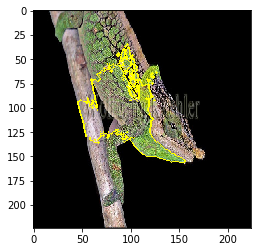

In [8]:
# 特徴ピクセルの表示
temp, mask = vgg16_explanation.get_image_and_mask(vgg16_explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [9]:
# lime の出力 (mask の結果) を DeepExplorer のノイズブロックの位置に使えるように変換する
# 特定サイズの矩形で、最も1(maskされている=limeによって特徴的であると判断された場所)が含まれる個数が多い場所を求める
# 評価が同じ矩形が複数あった場合は最初のひとつを保持する

def get_rectangle_good_2_noise(nparray, rectangle_size=(30, 30)):
    max_x = 0
    max_y = 0
    max_score = 0
    sizeof_x = len(nparray[0])
    sizeof_y = len(nparray)
    print(len(nparray[0]))
    print(len(nparray))
    for y in range(0, sizeof_y):
        for x in range(0, sizeof_x):
            fixed_y = y+rectangle_size[0]
            fixed_x = x+rectangle_size[1]
            score = np.sum(nparray[y:fixed_y, x:fixed_x])
            #print(image[y:fixed_y, x:fixed_x])
            #print("x:%d  y:%d" % (x, y))
            #print("score: %d" % score)
            #print("")
            if score > max_score:
                max_x = x
                max_y = y
                max_score = score
    print("max score : %d" % max_score)
    print("rectangle x : %d  y : %d" % (max_x, max_y))
    return (max_x, max_y, max_score)

# lime 用の 4角マスクデータを作るよ
def create_my_mask(target_size=(224,224), x_start=0, y_start=0, rectangle_size=(30, 30)):
  my_mask = np.zeros(target_size, dtype = int)
  x_end = x_start + rectangle_size[0]
  y_end = y_start + rectangle_size[1]
  my_mask[y_start:y_end, x_start:x_end]=1
  return my_mask

target_block_size = (60, 60)
(start_x, start_y, score) = get_rectangle_good_2_noise(mask, target_block_size)
my_mask = create_my_mask((224, 224), start_x, start_y, target_block_size)


224
224
max score : 3102
rectangle x : 60  y : 70


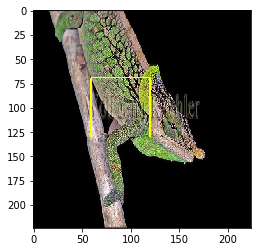

In [10]:
# DeepExplorer 向けのブロックノイズ位置の出力
np.set_printoptions(threshold=224*224)
temp, mask = vgg16_explanation.get_image_and_mask(vgg16_explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, my_mask))


In [0]:
# ここまで lime 実行〜出力を DeepExplorer で利用できるようにする準備
# ここから DeepExplorer の実行